-------------------------------------------------------------------------------------------------------------------------------


# DSL Case Study : Sales Prediction

-------------------------------------------------------------------------------------------------------------------------------

# Defining Problem Statement & import data

## Problem Statement

ABC Inc is a US based specialty retailer of crafts and fabrics. ABC Inc wants to predict the sales of their products based on historic sales. They already have a forecasting system in place, but its accuracy is low.  Sales forecast will feed into the budget planning and hence needs to have good accuracy. As an analytics consultant, ABC Inc have approached you to build a forecasting system with good accuracy.	
The retailer runs promotions at different parts of the year with an expectation to increase the margin. Given the daily sales data for 2017, 2018 and 2019 at Product level and the Promotion Calendar, you need to predict the sales of the products for the time-period: 1st Jan’2020 to 31st March’2020


## Datasets
- 1.	Sales Data – Sales data at day level with promotions on each day
- 2.	Promotion Calendar – Promotion calendar for the future period
- 3.	Product Master – Product hierarchy along with the Unit Retail Price of the product


## Data Dictionary

- 1.	Sales Data
    - a.	Product : Product of interest
    - b.	Date : Date on which the transaction is done
    - c.	Offer : Offer amount
    - d.	Offer Type : Type of the promotion 
    - e.	Quantity – Quantity sold for each day for each product
    
Note for offer type : There are 3 types of offers, which are given as P, F, and A.
    - P (Percentage offer) : 	 (Unit Retail Price is same as MRP)
    - F (Fixed offer) : Buy a product for $9.99. Regardless of the URP of the product, customer will get it for $9.99. For instance, if URP is $24.99, amount customer has to pay after promotion will be $9.99
    - A (Amount offer) : Buy a product for $9.99 off. This means that customer will get a discount of $9.99 on the URP. For instance, if URP is $24.99, amount customer has to pay after promotion will be $15

- 2.	Promotion Calendar
    - a.	Product : Product of interest
    - b.	Promotion Start : Start date of promotion
    - c.	Promotion End : End date of promtion
    - d.	Offer : Offer amount
    - e.	Offer Type : Type of promotion

- 3.	Product master
    - a.	Product : Product of interest
    - b.	Sub Category : Product hierarchy 1
    - c.	Category : Product hierarchy 2
    - d.	Unit Retail Price : Price of the product





--------------------------------------------------------------
--------------------------------------------------------------


# Approach to case study Solution


   - Clean the data
       - Check for duplicate rows
       - Check for rows with neagtive quantities sold
   - Preprocess & calculate important features:
       - **Percentage discounts** given for each product
       - **Unit Sales Price**
       - **Actual Sales** 
       - **Time based features** : Week number, Month, Year,  
    - Exploratory Data Analysis
        - Visualize presence of missing values for various product (Heatmap)
        - Pareto charts at Product level, Sub-category level & category level (check 80-20 rule)
        - Pick product which have significant contribution to total sales
    - Insights from EDA
    - Outlier & missing values treatment
    - Create exogenous variables to capture
        - Monthly factor of sales for each product
        - Weekly factor of sales for each product
        - Dicount percentage given for each product
    - Model Creation: Pick top contributing product
        - Create SARIMAX model, Hyperparameter tunning using Grid-Search
        - Plot predictions, calculate MAPE & RMSE in best case scenario
    - Using functions created above, create one function to repeat above steps for top 5 Products
        - Plot predictions, calculate MAPE & RMSE in best case scenario
    - Future scope of improvements
        


--------------------------------------------------------------
--------------------------------------------------------------


In [ ]:
#pip install pandas
#pip install matplotlib
#!pip install openpyxl
#!pip install plotly
#!pip install statsmodels

## Importing Libraries

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set(style = 'darkgrid')
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 100

import warnings # supress warnings
warnings.filterwarnings('ignore')

from matplotlib.ticker import PercentFormatter
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Importing data

In [2]:
product_master = pd.read_excel("C:\\Jupyter Notebooks\\Sales Prediction Case study\\Product Master.xlsx")
sales_data = pd.read_csv("C:\\Jupyter Notebooks\\Sales Prediction Case study\\Sales data.csv")
promotion_master = pd.read_excel("C:\\Jupyter Notebooks\\Sales Prediction Case study\\Promotion Master.xlsx")

In [3]:
product_master.sample(100).head(2)

Product     Sub Category     Category  UnitRetailPrice
130  Product 131  Sub Category 42  Category 14             9.99
19    Product 20  Sub Category 11   Category 6             7.99

In [4]:
sales_data.sample(100).head(2)

Product       Date    Offer OfferType  Quantity
29121  Product 106  6/12/2019  25% OFF         P      25.0
68666   Product 56  2/23/2018      NaN       NaN      31.0

In [5]:
promotion_master.sample(100).head(2)

Product Promotion start Promotion end    Offer Offer_Type
172  Product 155      2020-02-27    2020-03-11  40% OFF          P
684  Product 197      2020-03-21    2020-03-21  30% OFF          P

## Preprocessing & Feature Creation

In [10]:
def preProcess(df, product_master):
    #converting DateTime Format
    df['Date'] =  pd.to_datetime(df['Date'])  
    
    #Calculating Discount percentage given for each transaction
    df['Offer_temp'] = df['Offer'].astype('str').str.replace(' ', '').str.replace('$', '').str.replace('%', '').str.replace('OFF', '')
    df['Offer_temp'] = df['Offer_temp'].astype('float')
    df = pd.merge(df, product_master, on='Product',how='left')
    df.loc[df['OfferType'] == 'A', 'UnitSalesPrice']  = df['UnitRetailPrice'] - df['Offer_temp']
    df.loc[df['OfferType'] == 'F', 'UnitSalesPrice']  = df[['Offer_temp','UnitRetailPrice']].min(axis=1)
    df.loc[df['OfferType'] == 'P', 'UnitSalesPrice']  = (1- (df['Offer_temp']/100)) * df['UnitRetailPrice'] 
    df.loc[df['OfferType'].isna(), 'UnitSalesPrice'] = df['UnitRetailPrice']
    df['DiscountPercentage'] = ((df['UnitRetailPrice'] - df['UnitSalesPrice'])*100 / df['UnitRetailPrice']).round(2)
    df.drop(columns = ['Offer_temp', 'Offer', 'OfferType'], inplace = True)
    
    #Calculating Actual Sales
    df['ActualSales'] = df['UnitSalesPrice'] * df['Quantity']
    
    #Creating new features from Date Time
    df["Day"] = df['Date'].dt.day
    df['WeekNumber'] = df['Date'].dt.isocalendar().week
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Year_Week'] = df['Year'].astype(str) + '_' +  df['WeekNumber'].astype(str).str.zfill(2)
        
    return df


In [11]:
sales = preProcess(sales_data, product_master)

In [12]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128181 entries, 0 to 128180
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Product             128181 non-null  object        
 1   Date                128181 non-null  datetime64[ns]
 2   Quantity            128181 non-null  float64       
 3   Sub Category        128181 non-null  object        
 4   Category            128181 non-null  object        
 5   UnitRetailPrice     128181 non-null  float64       
 6   UnitSalesPrice      128181 non-null  float64       
 7   DiscountPercentage  128181 non-null  float64       
 8   ActualSales         128181 non-null  float64       
 9   Day                 128181 non-null  int32         
 10  WeekNumber          128181 non-null  UInt32        
 11  Year                128181 non-null  int32         
 12  Month               128181 non-null  int32         
 13  Year_Week           128181 no

In [13]:
sales.sample(100).head()

Product       Date  Quantity     Sub Category     Category   
81255    Product 76 2018-08-01      29.0  Sub Category 32  Category 14  \
35577    Product 91 2019-04-12      50.0  Sub Category 35  Category 15   
15509    Product 49 2017-11-03      54.0  Sub Category 24  Category 12   
97883    Product 85 2018-11-30      63.0  Sub Category 35  Category 15   
121778  Product 102 2017-05-24      43.0  Sub Category 35  Category 15   

        UnitRetailPrice  UnitSalesPrice  DiscountPercentage  ActualSales  Day   
81255              4.99          4.9900                 0.0     144.7100    1  \
35577              2.99          2.9900                 0.0     149.5000   12   
15509              6.49          6.4900                 0.0     350.4600    3   
97883              7.99          5.9925                25.0     377.5275   30   
121778             2.99          2.9900                 0.0     128.5700   24   

        WeekNumber  Year  Month Year_Week  
81255           31  2018      8   2018_31  
35577           15  2019      4   2019_15  
15509           44  2017     11   2017_44  
97883           48  2018     11   2018_48  
121778          21  2017      5   2017_21

In [14]:
#Checking if there are any negative values in Quantity
sales.loc[sales.Quantity < 0]

Empty DataFrame
Columns: [Product, Date, Quantity, Sub Category, Category, UnitRetailPrice, UnitSalesPrice, DiscountPercentage, ActualSales, Day, WeekNumber, Year, Month, Year_Week]
Index: []

In [15]:
#Checking duplicates in data
sales[sales.duplicated()]

Empty DataFrame
Columns: [Product, Date, Quantity, Sub Category, Category, UnitRetailPrice, UnitSalesPrice, DiscountPercentage, ActualSales, Day, WeekNumber, Year, Month, Year_Week]
Index: []

In [16]:
sales.describe(include = 'object')

Product     Sub Category     Category Year_Week
count        128181           128181       128181    128181
unique          197               61           21       156
top     Product 147  Sub Category 35  Category 15   2018_01
freq           1087            41678        48261       959

> No row has negative Quantity values, No Duplicate values in data

> 197 Unique Products, 61 Unique Sub-Categories, 21 Unique Categories

> 3 Years data given (i.e. 01 Jan 2017 to 31 Dec 2019)

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


## Exploratory Data Analysis

In [17]:
sales.describe(include = np.number, percentiles=[.25,.5,.75,.90,.95, .99, .999]).round(2).T

count     mean      std     min     25%     50%   
Quantity            128181.0   134.62   229.17    0.11    34.0    60.0  \
UnitRetailPrice     128181.0     8.19     7.22    0.79    3.49    5.99   
UnitSalesPrice      128181.0     7.36     6.55    0.47    2.99    5.49   
DiscountPercentage  128181.0     8.06    15.66     0.0     0.0     0.0   
ActualSales         128181.0   992.24  2101.52     0.5  146.58  271.66   
Day                 128181.0    15.69      8.8     1.0     8.0    16.0   
WeekNumber          128181.0    26.27    14.97     1.0    13.0    26.0   
Year                128181.0  2017.97     0.82  2017.0  2017.0  2018.0   
Month               128181.0     6.48     3.43     1.0     4.0     6.0   

                       75%      90%      95%      99%     99.9%       max  
Quantity             141.0   331.29   477.16  1082.38   2500.39    8458.0  
UnitRetailPrice       9.99    16.99    22.99    39.99     39.99     79.99  
UnitSalesPrice        8.99    14.95    19.99    39.99     39.99     79.99  
DiscountPercentage     0.0     30.0     40.0     60.0      80.0     92.36  
ActualSales         896.31  2547.33  4010.45  11103.5  20806.63  80221.19  
Day                   23.0     28.0     29.0     31.0      31.0      31.0  
WeekNumber            39.0     47.0     50.0     52.0      52.0      52.0  
Year                2019.0   2019.0   2019.0   2019.0    2019.0    2019.0  
Month                  9.0     11.0     12.0     12.0      12.0      12.0

In [18]:
#Checking presence of missing values for various product

product_date_pivot = sales.pivot_table(columns='Date', index= 'Product', 
                       values=['Quantity'], aggfunc='sum')

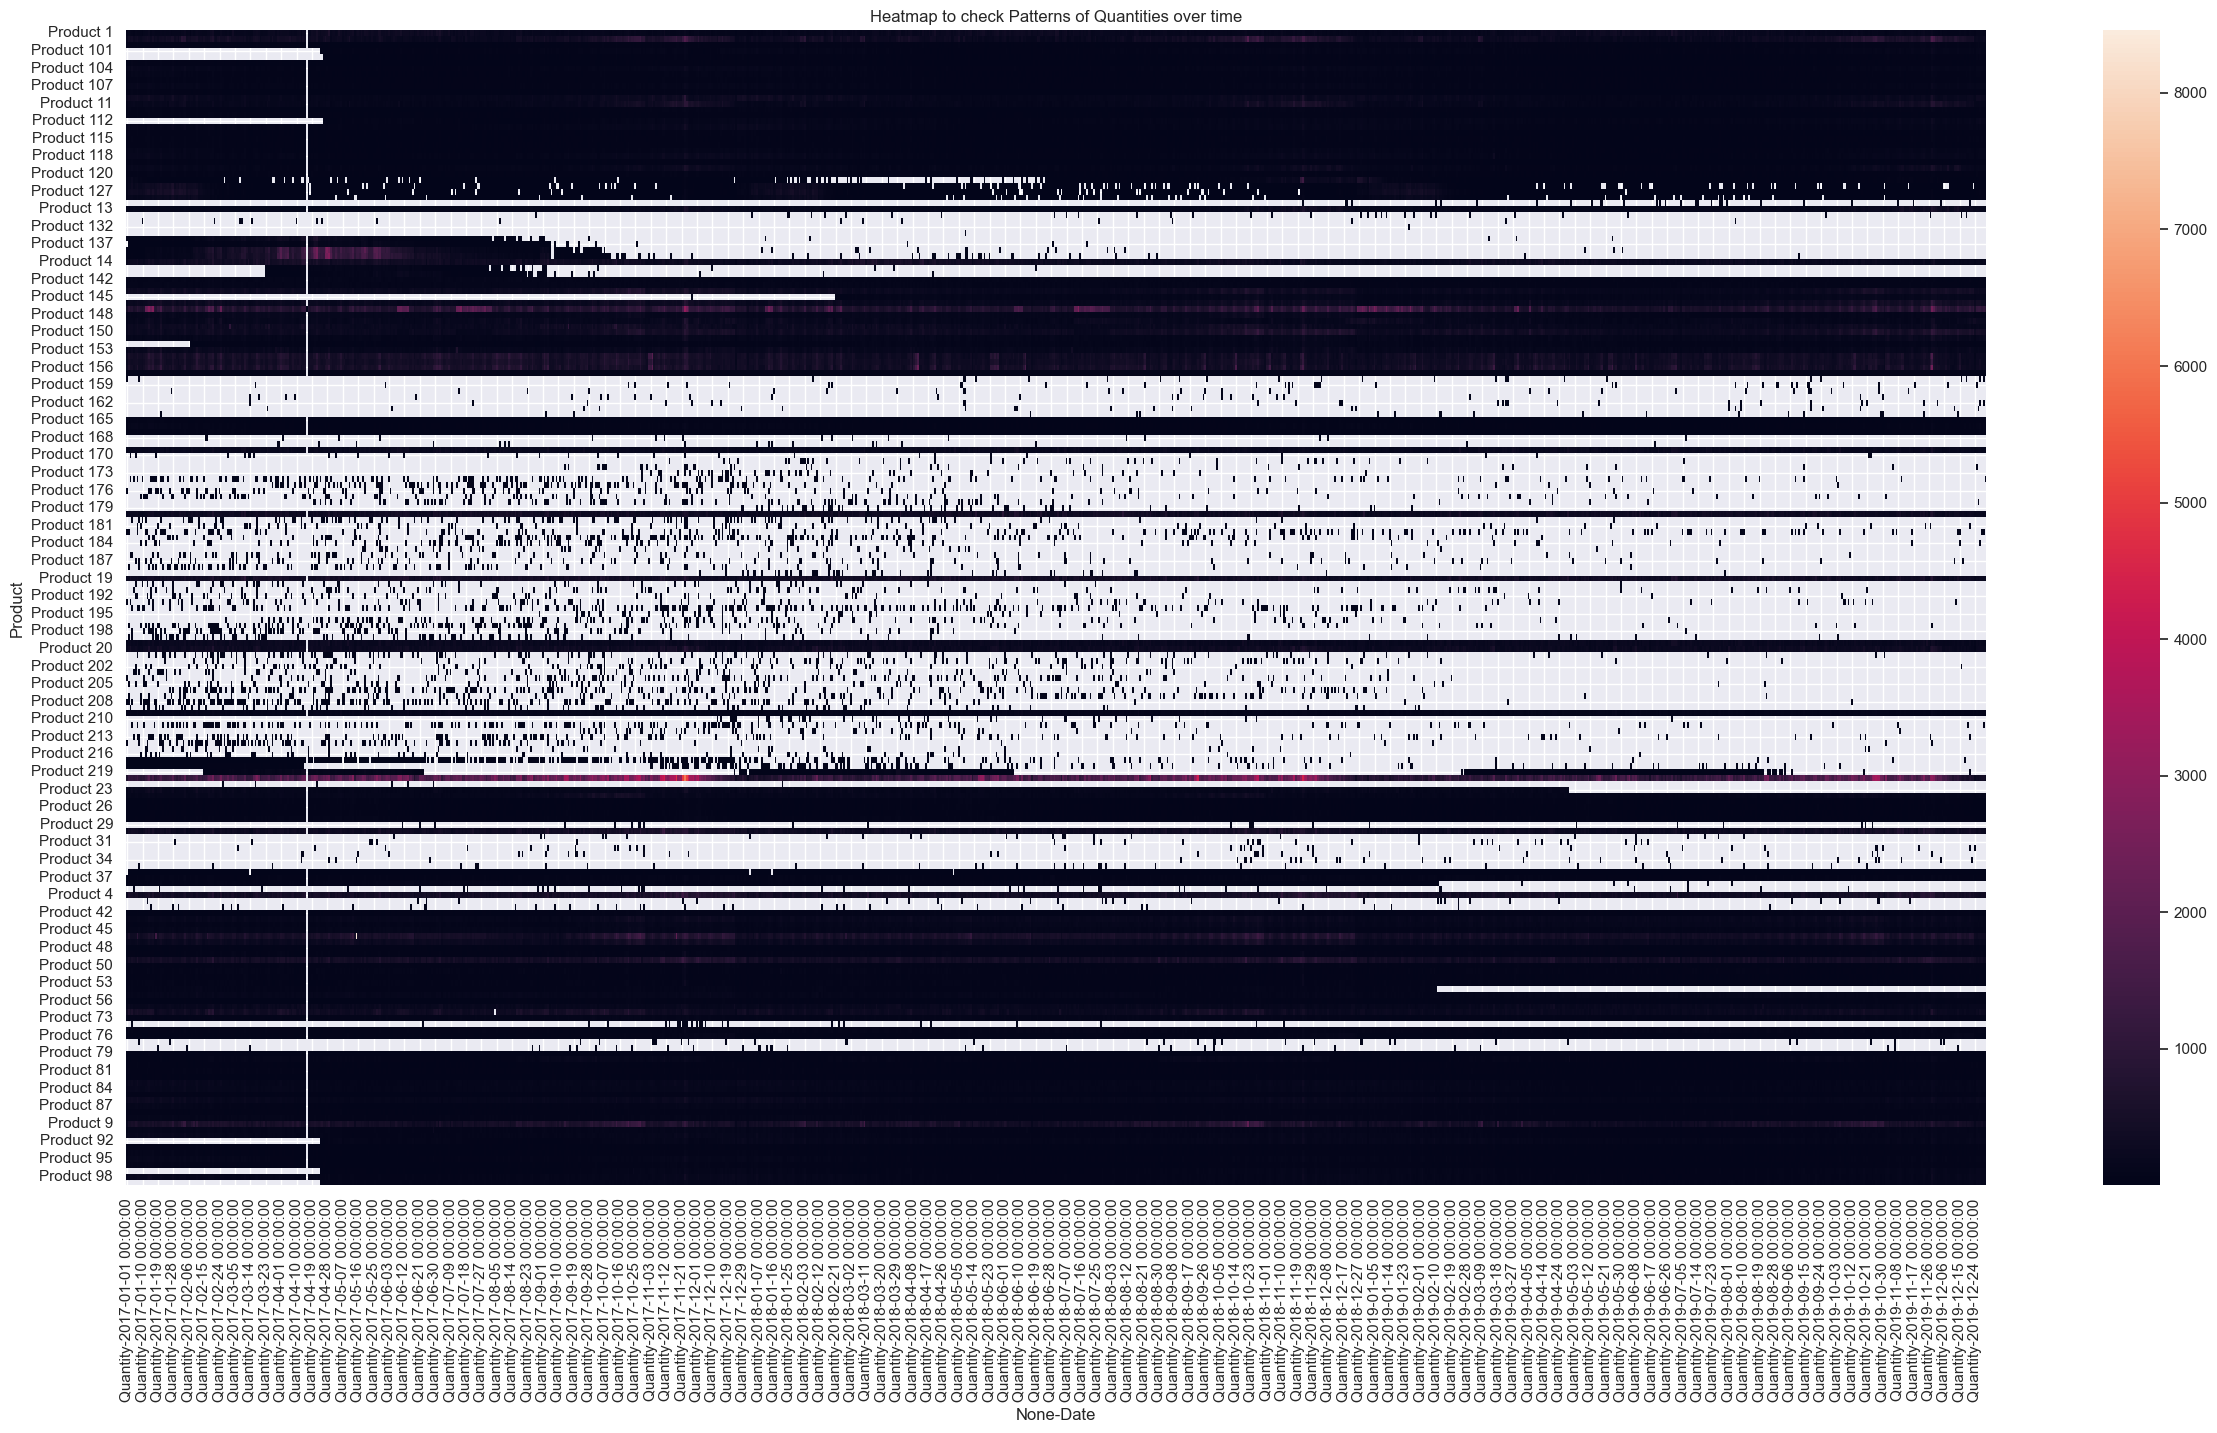

In [19]:
plt.figure(figsize=(30,15))
sns.heatmap(product_date_pivot)
plt.title('Heatmap to check Patterns of Quantities over time')
plt.show()

In [21]:
#Count of Products with significant amount of data of sales
sum(sales.Product.value_counts() > 766)

111

In [22]:
StableSalesProducts = list(sales.Product.value_counts()[sales.Product.value_counts() > 766].index)

In [23]:
StableSalesProducts[:10]

['Product 147',
 'Product 9',
 'Product 116',
 'Product 25',
 'Product 28',
 'Product 24',
 'Product 3',
 'Product 103',
 'Product 105',
 'Product 56']

> 111 products (~56% of Products) have stable Sales

In [24]:
#Product wise Revenue Contribution

product_revenue_pivot = sales.pivot_table(index= 'Product', 
                                          values=['ActualSales'], 
                                          aggfunc='sum').round().sort_values(by=['ActualSales'],ascending=[False])

product_revenue_pivot["cum_percentage"] = round(product_revenue_pivot["ActualSales"].cumsum()/product_revenue_pivot["ActualSales"].sum()*100,2)

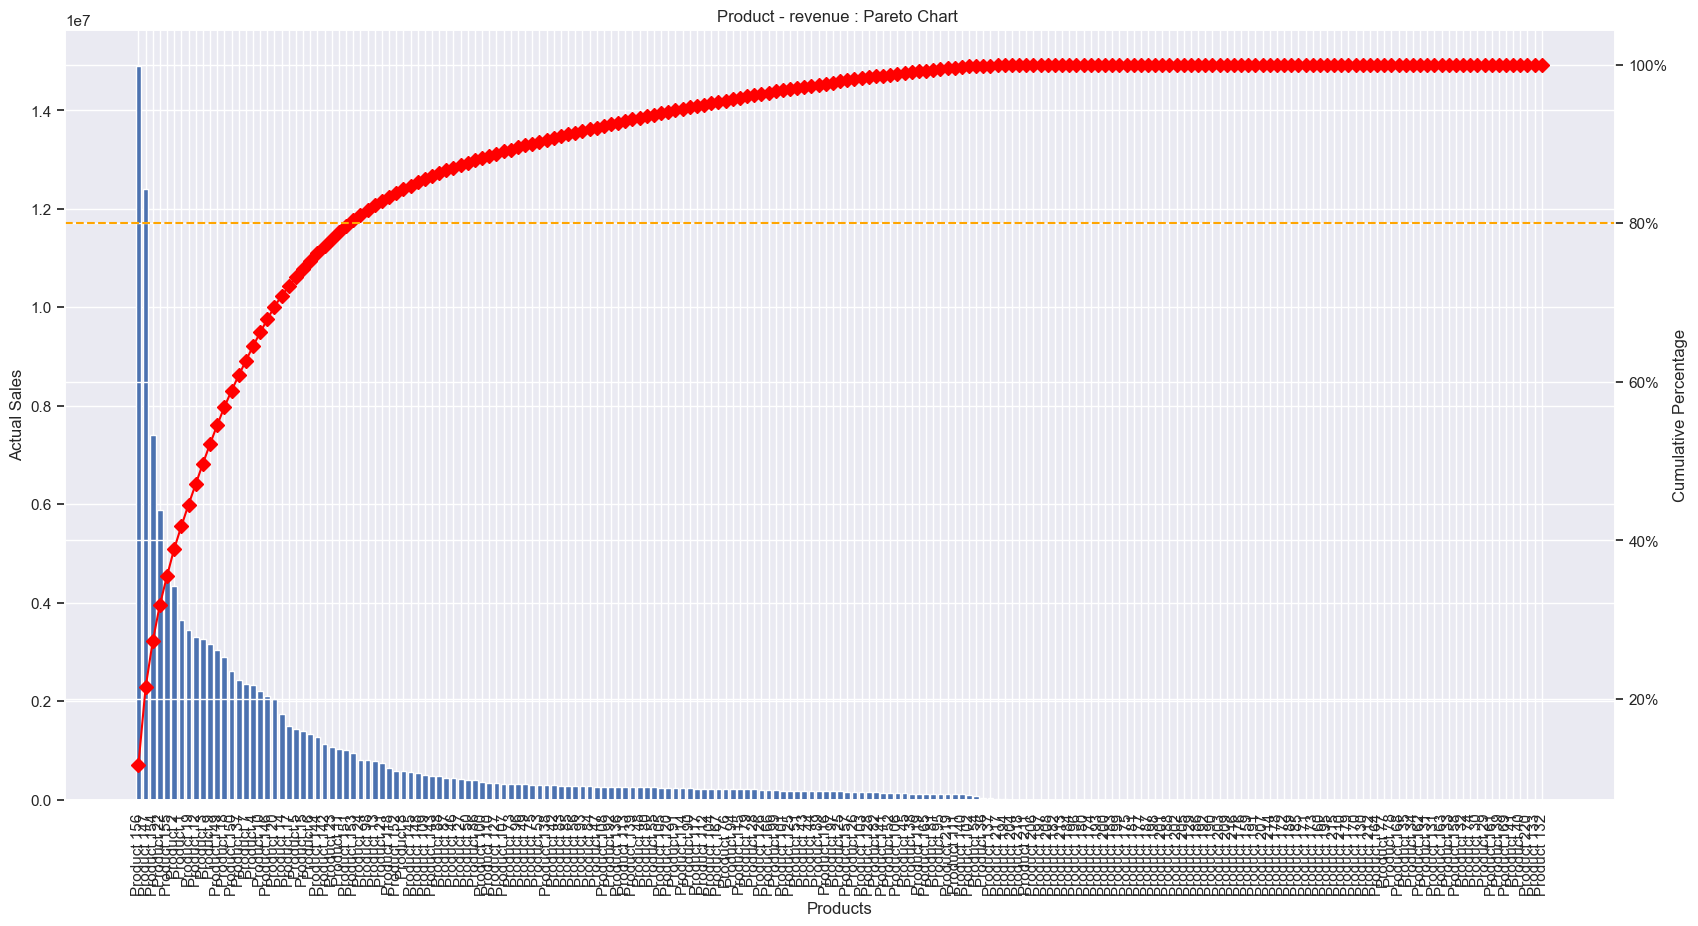

In [25]:
# Product - revenue : Pareto Chart 
fig, ax = plt.subplots(figsize=(20,10))

ax.bar(product_revenue_pivot.index, product_revenue_pivot["ActualSales"])
ax.set_title("Product - revenue : Pareto Chart ")
ax.set_xlabel("Products")
ax.set_ylabel("Actual Sales")
plt.xticks(rotation=90)

ax2 = ax.twinx()
ax2.plot(product_revenue_pivot.index, product_revenue_pivot["cum_percentage"], color="red", marker="D", ms=7)
ax2.axhline(80, color="orange", linestyle="dashed")
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel("Cumulative Percentage")
plt.show()

In [26]:
SignificantSalesProducts = list(product_revenue_pivot[product_revenue_pivot.cum_percentage <= 80].index)

In [27]:
len(SignificantSalesProducts)

30

In [28]:
product_revenue_pivot[:5]

ActualSales  cum_percentage
Product                                 
Product 156   14893717.0           11.71
Product 147   12408976.0           21.47
Product 154    7415397.0           27.30
Product 22     5880572.0           31.92
Product 155    4626245.0           35.56

> 30 products (~15% products) contribute to 80% of total revenue

In [29]:
#Sub-category wise Revenue Contribution

subcategory_revenue_pivot = sales.pivot_table(index= 'Sub Category', 
                                          values=['ActualSales'], 
                                          aggfunc='sum').round().sort_values(by=['ActualSales'],ascending=[False])

subcategory_revenue_pivot["cum_percentage"] = round(subcategory_revenue_pivot["ActualSales"].cumsum()/subcategory_revenue_pivot["ActualSales"].sum()*100,2)

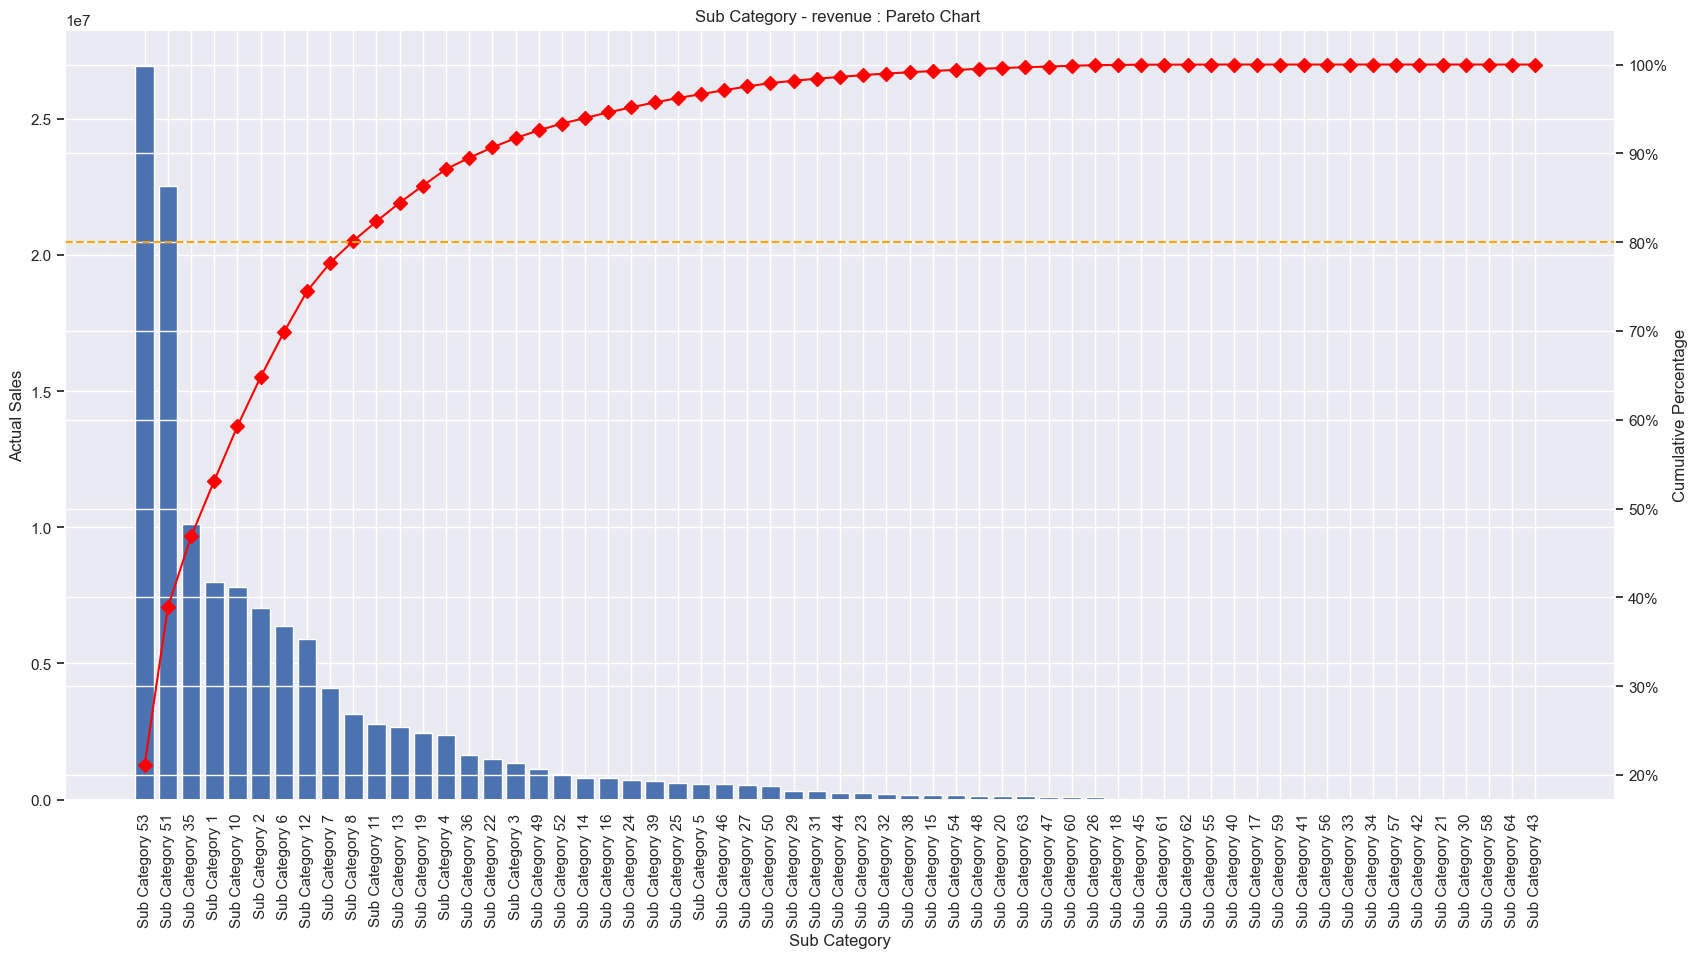

In [30]:
# Sub Category - revenue : Pareto Chart 
fig, ax = plt.subplots(figsize=(20,10))

ax.bar(subcategory_revenue_pivot.index, subcategory_revenue_pivot["ActualSales"])
ax.set_title("Sub Category - revenue : Pareto Chart ")
ax.set_xlabel("Sub Category")
ax.set_ylabel("Actual Sales")
plt.xticks(rotation=90)

ax2 = ax.twinx()
ax2.plot(subcategory_revenue_pivot.index, subcategory_revenue_pivot["cum_percentage"], color="red", marker="D", ms=7)
ax2.axhline(80, color="orange", linestyle="dashed")
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel("Cumulative Percentage")
plt.show()

In [31]:
SignificantSalesSubcategory = list(subcategory_revenue_pivot[subcategory_revenue_pivot.cum_percentage <= 81].index)

In [32]:
len(SignificantSalesSubcategory)

10

> 10 Sub Categories (~16% Sub Categories) contribute to 80% of total revenue

In [33]:
#Category wise Revenue Contribution

category_revenue_pivot = sales.pivot_table(index= 'Category', 
                                          values=['ActualSales'], 
                                          aggfunc='sum').round().sort_values(by=['ActualSales'],ascending=[False])

category_revenue_pivot["cum_percentage"] = round(category_revenue_pivot["ActualSales"].cumsum()/category_revenue_pivot["ActualSales"].sum()*100,2)

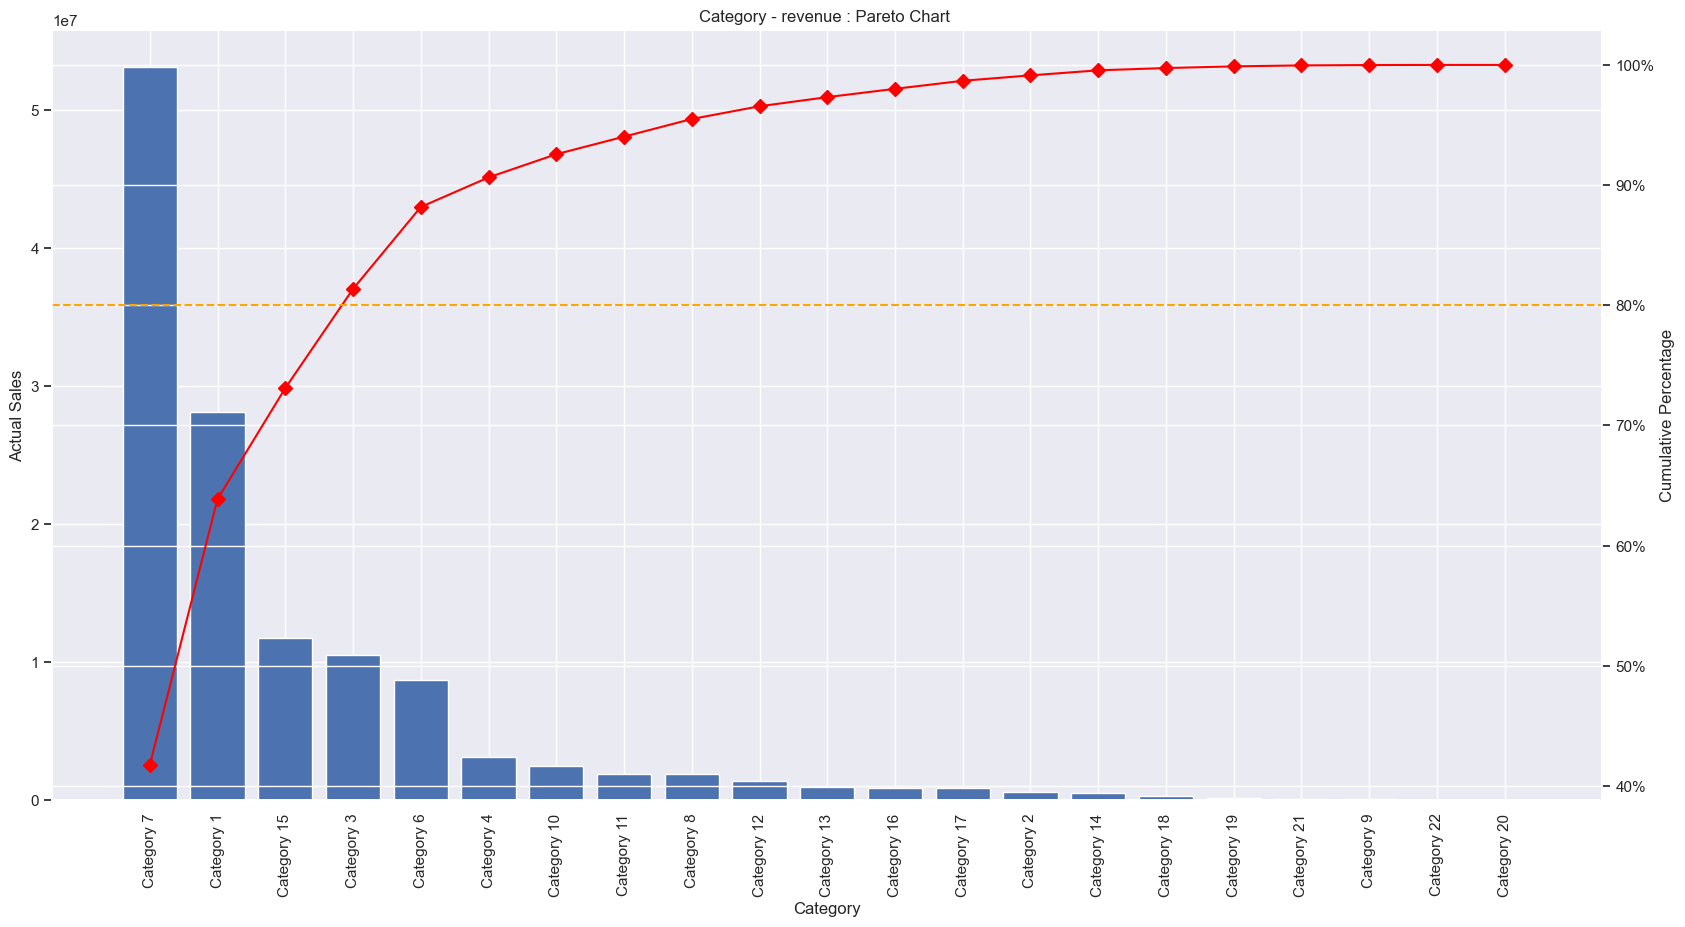

In [34]:
# Category - revenue : Pareto Chart 
fig, ax = plt.subplots(figsize=(20,10))

ax.bar(category_revenue_pivot.index, category_revenue_pivot["ActualSales"])
ax.set_title("Category - revenue : Pareto Chart ")
ax.set_xlabel("Category")
ax.set_ylabel("Actual Sales")
plt.xticks(rotation=90)

ax2 = ax.twinx()
ax2.plot(category_revenue_pivot.index, category_revenue_pivot["cum_percentage"], color="red", marker="D", ms=7)
ax2.axhline(80, color="orange", linestyle="dashed")
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel("Cumulative Percentage")
plt.show()

In [35]:
SignificantSalesCategory = list(category_revenue_pivot[category_revenue_pivot.cum_percentage <= 82].index)

In [36]:
SignificantSalesCategory

['Category 7', 'Category 1', 'Category 15', 'Category 3']

> 4 Categories (~20% Categories) are contributing to 80% of total revenue

----------------------------------------------------------------


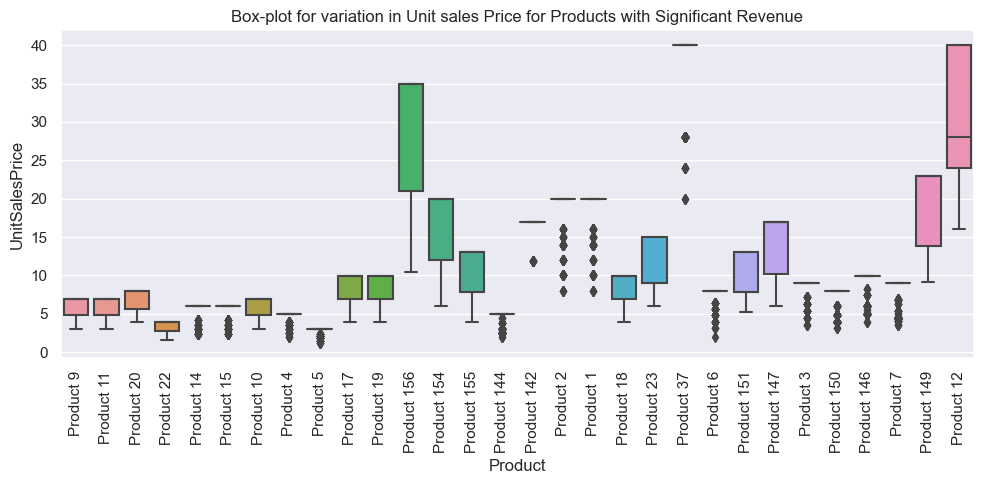

In [37]:
#Box-plot for variation in Unit sales Price for Products with Significant Revenue

plt.figure(figsize=(10,5))
sns.boxplot(y=sales[sales.Product.isin(SignificantSalesProducts)]['UnitSalesPrice'], 
            x =sales[sales.Product.isin(SignificantSalesProducts)]['Product'] ) 
plt.xticks(rotation=90)
plt.title("Box-plot for variation in Unit sales Price for Products with Significant Revenue")
plt.tight_layout()
plt.show()


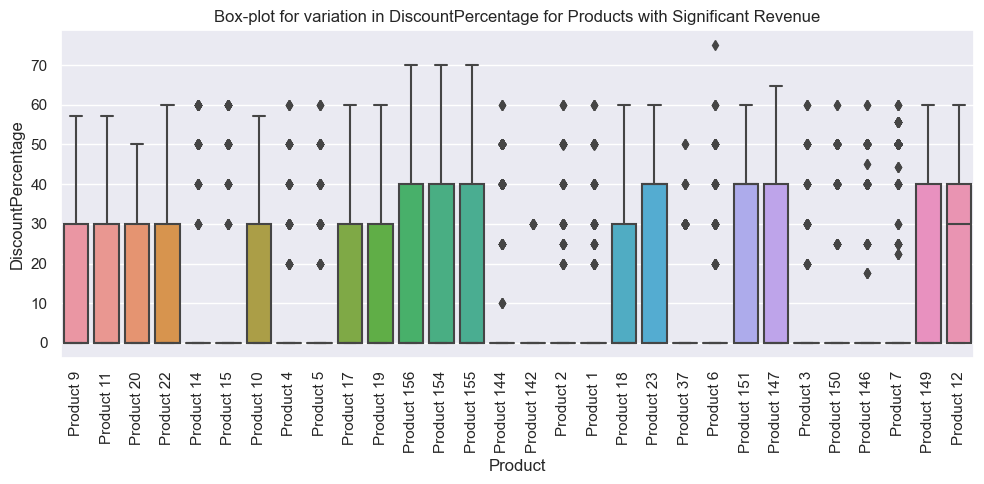

In [38]:
#Box-plot for variation in Discount percentage for Products with Significant Revenue

plt.figure(figsize=(10,5))
sns.boxplot(y=sales[sales.Product.isin(SignificantSalesProducts)]['DiscountPercentage'], 
            x =sales[sales.Product.isin(SignificantSalesProducts)]['Product'] ) 
plt.xticks(rotation=90)
plt.title("Box-plot for variation in DiscountPercentage for Products with Significant Revenue")
plt.tight_layout()
plt.show()

In [39]:
#Overall Monthly Revenue trend
df= sales.pivot_table(index= ['Year', 'Month'], values=['ActualSales'],aggfunc='sum').round().reset_index()
df.index = df['Year'].astype(str) + '_' +  df['Month'].astype(str).str.zfill(2)
fig = px.line(df, x=df.index, y="ActualSales", title='Monthly Revenue')
fig.show()

#overall trend in sales is negative.
#While predicting sales year is important factor to be considered. 
#Predicted sales values should be less than previous years sales values.

In [40]:
#Monthly sales over various years
df= sales.pivot_table(index= ['Year', 'Month'], values=['ActualSales'],aggfunc='sum').round().reset_index()
fig = px.line(df, x='Month', y="ActualSales", color='Year', title='Monthly Revenue over years')
fig.show()

#Strong Seasonality can be observed in Monthly Sales.
#Month 10 & 11 have higher sales
#Products sold have seasonal products.

In [41]:
#Weekly sales over various years
df= sales.pivot_table(index= ['Year', 'WeekNumber'], values=['ActualSales'],aggfunc='sum').round().reset_index()
fig = px.line(df, x='WeekNumber', y="ActualSales", color='Year', title='Weekly Sales for various Years')
fig.show()

#Seasonal patterns are observed on Weekly levels as well. 
#example Weeknumber 45 has high & weeknumber 44 has dip

In [42]:
df= sales.pivot_table(index= ['Day', 'Month', 'Year'], values=['ActualSales'],aggfunc='sum').round().reset_index()
df.index = df['Year'].astype(str) + '_' +  df['Month'].astype(str).str.zfill(2)
fig = px.line(df, x='Day', y="ActualSales", color=df.index, title='Daily Sales for various Years & Month')
fig.show()

#No visible patterns observed at day level for each month.

In [43]:
#plotting demand of single product to visualize
df = sales.loc[sales.Product == SignificantSalesProducts[0], ['Date', 'Quantity']]
fig = px.line(df, x='Date', y="Quantity", title='Daily Quantity for Product 156 ')
fig.show()

In [44]:
#plotting demand of 5 products to visualize
df = sales.loc[sales.Product.isin(SignificantSalesProducts[0:5]), ['Product','Date','Quantity']]
fig = px.line(df, x='Date', y="Quantity", color= 'Product', title='Daily Quantity for Products with Stable Sales')
fig.show()

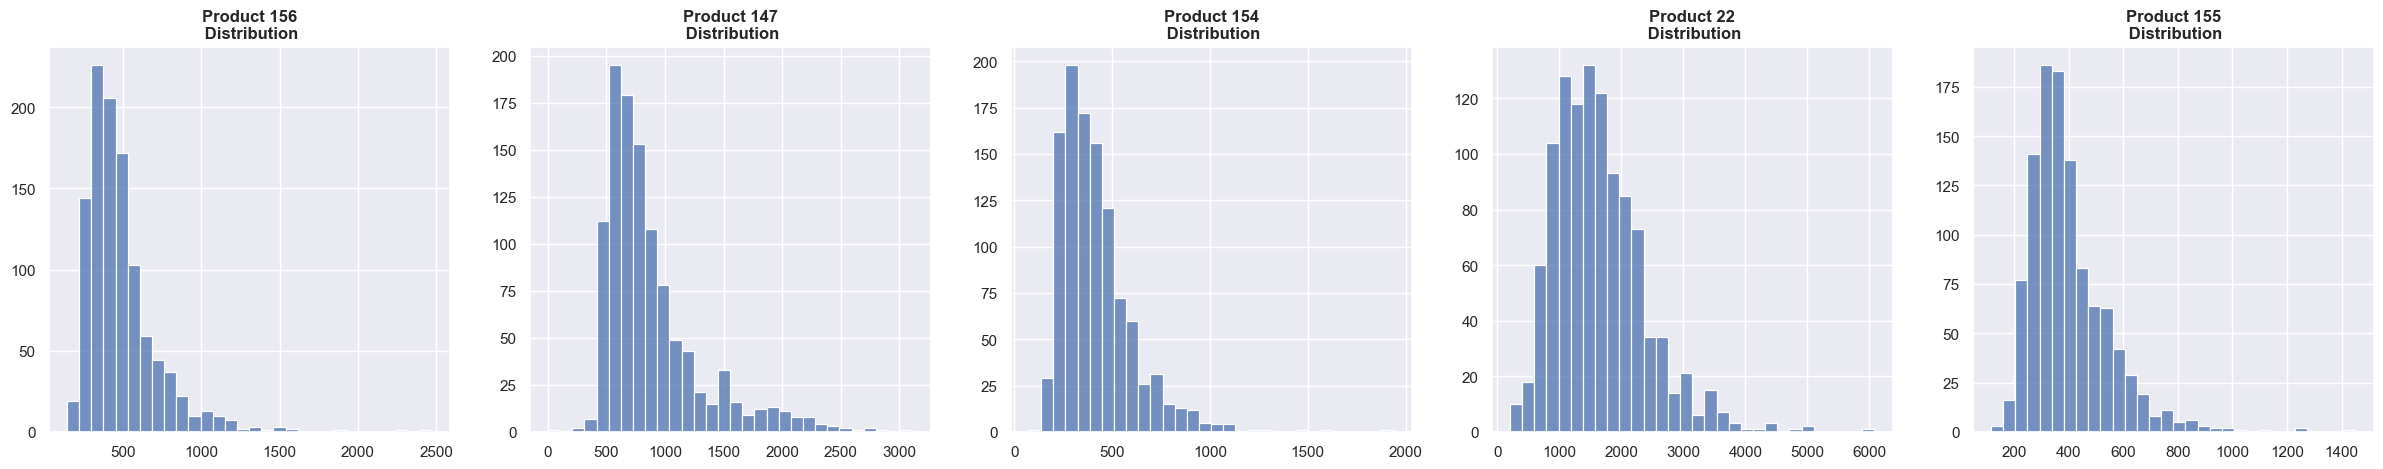

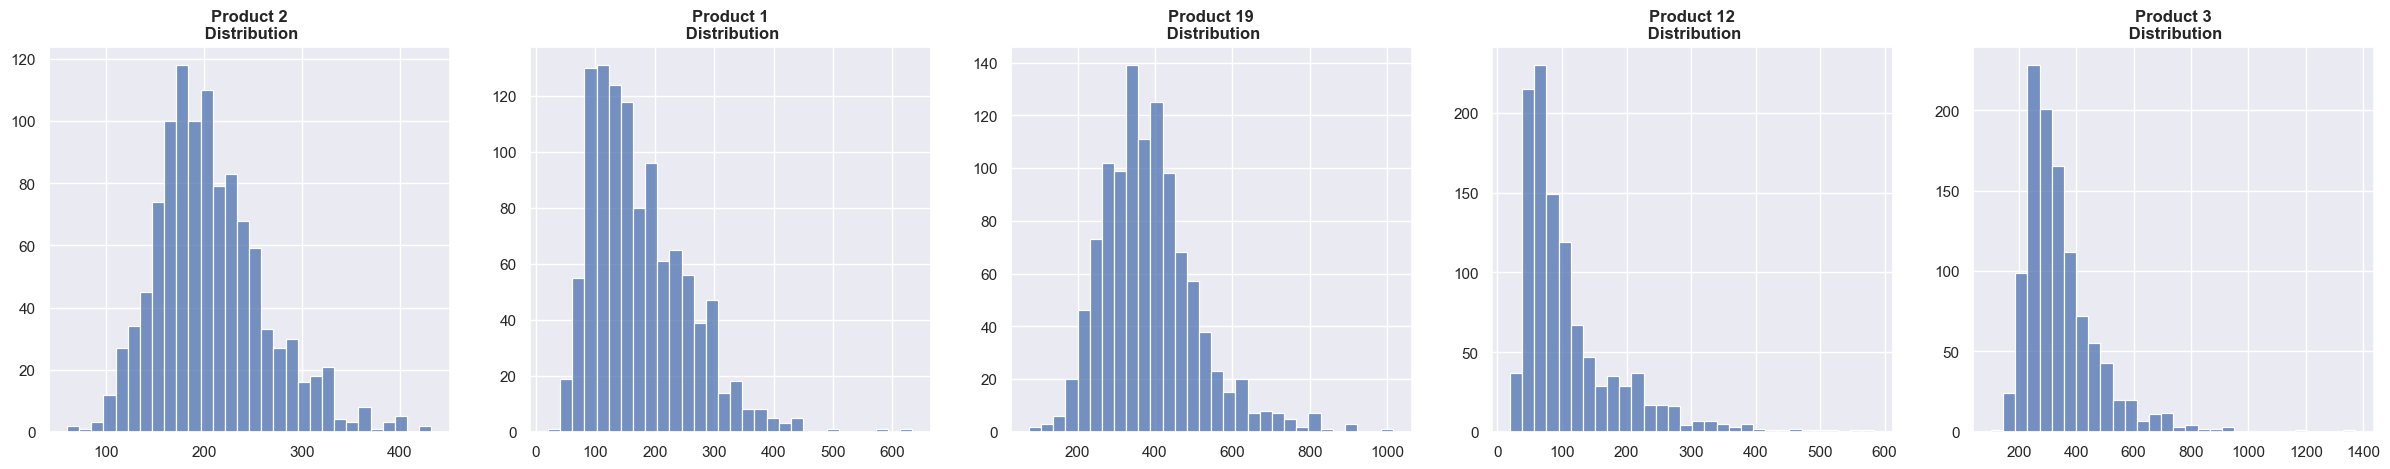

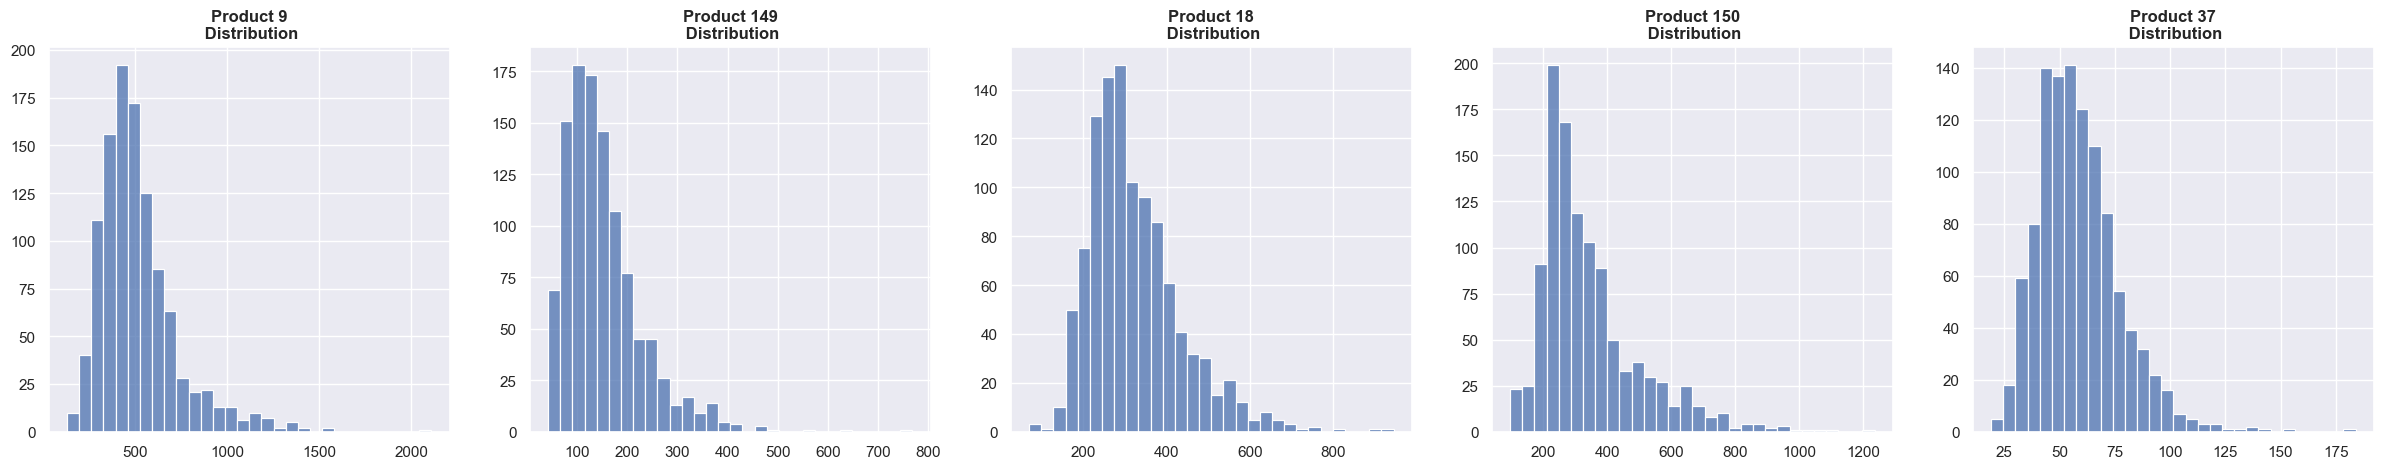

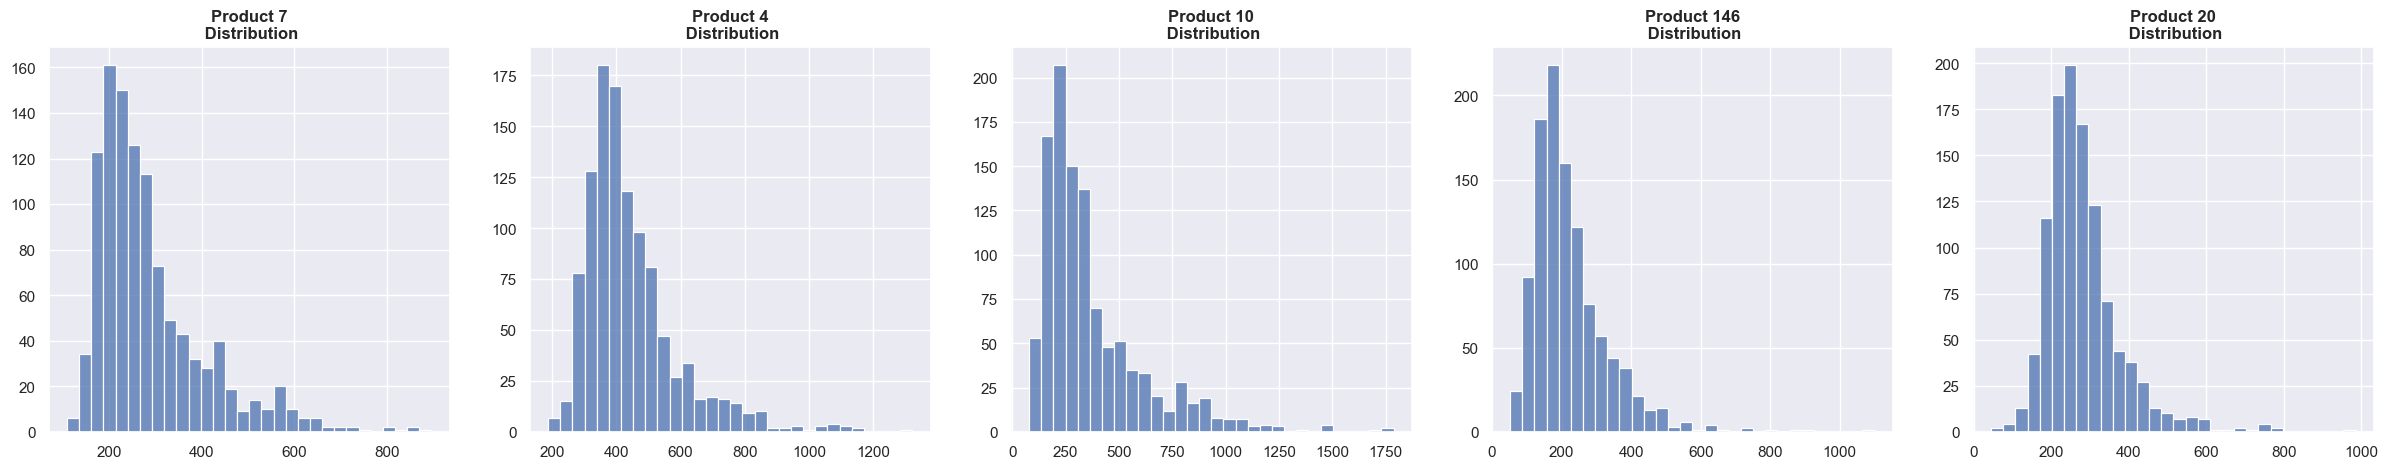

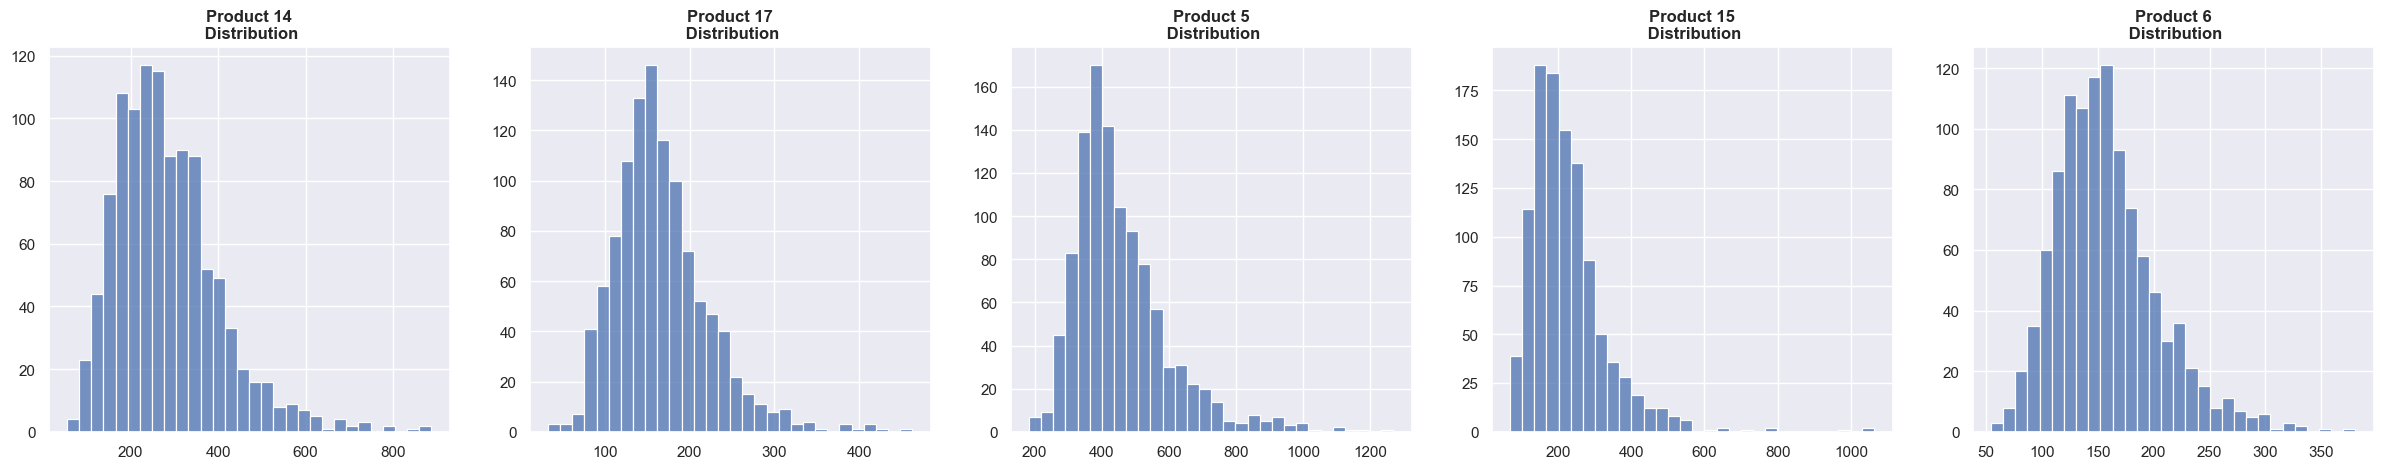

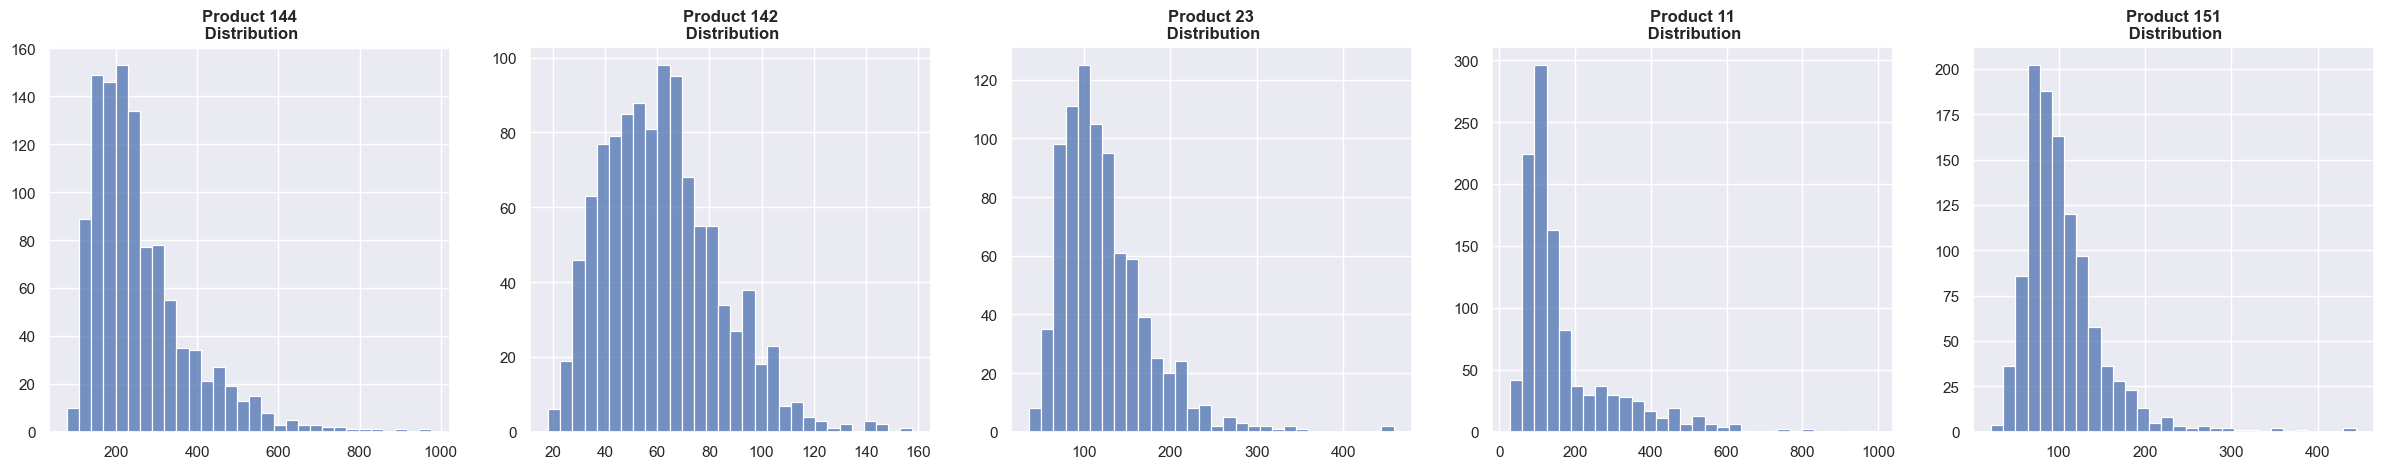

In [45]:
#Histogram of Daily Quantities for Products with Significant sales
num_cols = 5

start = 0
end = start + num_cols

for j in range(6):
    columns = SignificantSalesProducts[start:end]
    plt.figure(figsize=(30,5))
    for index, column in enumerate(columns):
        plt.subplot(1,len(columns),index+1)
        temp = sales.loc[sales.Product == column, ['Quantity']]
        sns.histplot(x='Quantity', data=temp, bins = 30)
        plt.ylabel('')
        plt.xlabel('')
        plt.title(column + '\n Distribution', fontsize = 12, fontweight = 'bold')
    plt.show()
    start = end
    end = start + num_cols


> For all Products (with Significant Sales) the histogram is Right Skewed.
> Hence for removing outliers, we will cap the daily quantity to 99 percentile.

--------------------------------------------------------------
--------------------------------------------------------------


## Insights based on EDA:


- At daily level, most of the time, **quantities sold are below 1000 for all products.**
- Various types of sales patterns are observed in data shared. 
- Continuous sales patterns examples :   product 11, 107, 81, 84, 9
- Discontinuous sales patterns examples: product 205, 208, 184, 187
- Almost No sales for complete duration: product 132, 31, 34, 77, 172
- Discontinued sales product examples: 137, 138



- There are **few days (i.e. 16-04-2017, 23-11-2017, 25-12-2017, 01-04-2018, 22-11-2018, 25-12-2018, 21-04-2019, 28-11-2019, 25-12-2019 ) for which sales data is missing** for all products. There is a possibility of **technical failure (system breakdown) or Holiday across all stores.**



- Products with "Discontinuous sales", "Almost no sales" & "Discontinued sales" patterns should be separated. Predicting sales of these products is difficult and need special treatments. In this case study, I have excluded these products while predicting sales.



- On an average **"118 Products"** are sold on each day. We should identify these products and predict sales for these products for this case study. 
- Products for which no quantities were sold in last two months are considered as **Discontinued products**. These products are also excluded from further analysis 
- Products where **less than 70% of total sales values (i.e. < 766) values are present,** I have excluded those products from sales prediction. Hence **only 111 products are considered for further analysis and prediction.**



- Product - revenue : Pareto Chart 
> 30 products (~15% products) contribute to 80% of total revenue


- Sub Category - revenue : Pareto Chart 
> 10 Sub Categories (~16% Sub Categories) contribute to 80% of total revenue

- Category - revenue : Pareto Chart 
> 4 Categories (~20% Categories) are contributing to 80% of total revenue




 - Strong Seasonality can be observed in Monthly Sales.
> Month 10 & 11 have higher sales
> Products sold have seasonal products.


- Seasonal patterns are observed on Weekly levels as well. 
> example Weeknumber 45 has high & weeknumber 44 has dip


- No visible patterns observed at day level for each month.


- Histogram of Daily Quantities for Products with Significant sales
> For all Products (with Significant Sales) the histogram is Right Skewed. Hence for removing outliers, we will cap the daily quantity to 99 percentile.

--------------------------------------------------------------
--------------------------------------------------------------

## Outlier & missing values treatment

In [142]:
#Creating list of top 10 products and filtering sales data for training model for forecast

top10products = SignificantSalesProducts[:10]
df_sales = sales.loc[sales.Product.isin(top10products),]


In [236]:
#Function for Outlier treatment and filling missing values
def outlier_missing(product, df_sales):
    #Filter rows from mail sales data for product
    df_product = df_sales.loc[df_sales.Product == product,]
    
    #Clipping quantity to 99th percentile to remove outliers
    percentile99 = df_product['Quantity'].quantile(.99)
    df_product['Quantity'] = df_product['Quantity'].clip(upper = percentile99, axis=0)
    
    #Filling missing values based on interpolate function
    time_sdata = pd.date_range("01/01/2017", periods=1095, freq="D")
    time_df = pd.DataFrame(index=time_sdata).reset_index()
    df_product = time_df.merge(df_product, how = 'left', left_on='index', right_on='Date')
    df_product = df_product.drop(columns = ['index'])
    df_product['Quantity'] = df_product['Quantity'].interpolate()
    df_product['Quantity']
    df_product.set_index('Date', inplace = True)
    
    return df_product

## Creating exogenous variables

In [144]:
df_Product156 = outlier_missing(top10products[0], df_sales)

In [147]:
#Creating Function for exogenous variable

def exogenous_variable(df_Product):
    #Creating exogenous variable of Discounts
    exog_discount = df_Product['DiscountPercentage'].values

    #Creating exogenous variable of Month Factor
    mean_quantity = df_Product['Quantity'].mean().round(2)
    month_factor = df_Product.pivot_table(index= 'Month', values=['Quantity'],aggfunc='mean').round().reset_index()
    month_factor.Quantity = month_factor.Quantity/ mean_quantity
    month_factor = pd.merge(df_Product['Month'], month_factor, how = 'left', left_on='Month', right_on='Month')
    month_factor = month_factor.Quantity.values

    #Creating exogenous variable of Week Factor
    week_factor = df_Product.pivot_table(index= 'WeekNumber', values=['Quantity'],aggfunc='mean').round().reset_index()
    week_factor.Quantity = week_factor.Quantity/ mean_quantity
    week_factor = pd.merge(df_Product['WeekNumber'], week_factor, how = 'left', left_on='WeekNumber', right_on='WeekNumber')
    week_factor = week_factor.Quantity.values
    
    #Creating combine exogenous variable dataframe
    exog = pd.DataFrame(columns = ['exog_discount','month_factor', 'week_factor'])
    exog['exog_discount'] = exog_discount
    exog['month_factor']  = month_factor
    exog['week_factor']   = week_factor
    exog = exog.ffill(axis = 0)
    
    return exog

In [173]:
exog_156 = exogenous_variable(df_Product156)

In [123]:
exog_156.head()

exog_discount  month_factor  week_factor
0            0.0      0.948633     0.689727
1            0.0      0.948633     0.735294
2            0.0      0.948633     0.735294
3            0.0      0.948633     0.735294
4            0.0      0.948633     0.735294

## Model Creation: Picking top contributing product

In [162]:
#Creating function to grid-search best hyperparameter for given product-quantity time series

def sarimax_grid_search(time_series, n, param, d_param, s_param, exog = []):
    counter = 0
    #creating df for storing results summary
    param_df = pd.DataFrame(columns = ['serial','pdq', 'PDQs', 'mape', 'rmse'])
    
    #Creating loop for every paramater to fit SARIMAX model
    for p in param:
        for d in d_param:
            for q in param:
                for P in param:
                    for D in d_param:
                        for Q in param:
                            for s in s_param:
                                #Creating Model
                                model = SARIMAX(time_series[:-n], 
                                                order=(p,d,q), 
                                                seasonal_order=(P, D, Q, s), 
                                                exog = exog[:-n],
                                                initialization='approximate_diffuse')
                                model_fit = model.fit()
                                
                                #Creating forecast from Model
                                model_forecast = model_fit.forecast(n, dynamic = True, exog = pd.DataFrame(exog[-n:]))
                                
                                #Calculating errors for results
                                actuals = time_series.values[-n:]
                                errors = time_series.values[-n:] - model_forecast.values
                                
                                #Calculating MAPE & RMSE
                                mape = np.mean(np.abs(errors)/ np.abs(actuals))
                                rmse = np.sqrt(np.mean(errors**2))
                                mape = np.round(mape,5)
                                rmse = np.round(rmse,3)
                                
                                #Storing the results in param_df
                                counter += 1
                                list_row = [counter, (p,d,q), (P,D,Q,s), mape, rmse]
                                param_df.loc[len(param_df)] = list_row
                                
                #print statement to check progress of Loop                
                print(f'Possible Combination: {counter} out of { (len(param)**4)*len(s_param)*(len(d_param)**2)} calculated')
                           
    return param_df     

In [174]:
#long time to execute
#Finding best parameters for Product-156 time series

time_series = df_Product156.Quantity
n = 90 
param = [0,1,2]
d_param = [0,1]
s_param = [7]
exog = exog_156.to_numpy()


params_Product156  = sarimax_grid_search(time_series, n, param, d_param,s_param, exog)

Possible Combination: 18 out of 324 calculated
Possible Combination: 36 out of 324 calculated
Possible Combination: 54 out of 324 calculated
Possible Combination: 72 out of 324 calculated
Possible Combination: 90 out of 324 calculated
Possible Combination: 108 out of 324 calculated
Possible Combination: 126 out of 324 calculated
Possible Combination: 144 out of 324 calculated
Possible Combination: 162 out of 324 calculated
Possible Combination: 180 out of 324 calculated
Possible Combination: 198 out of 324 calculated
Possible Combination: 216 out of 324 calculated
Possible Combination: 234 out of 324 calculated
Possible Combination: 252 out of 324 calculated
Possible Combination: 270 out of 324 calculated
Possible Combination: 288 out of 324 calculated
Possible Combination: 306 out of 324 calculated
Possible Combination: 324 out of 324 calculated


In [175]:
params_Product156.sort_values(['mape', 'rmse']).head()

serial        pdq          PDQs     mape     rmse
26      27  (0, 0, 1)  (1, 0, 2, 7)  0.23389  167.024
13      14  (0, 0, 0)  (2, 0, 1, 7)  0.23611  169.468
8        9  (0, 0, 0)  (1, 0, 2, 7)  0.23624  169.510
7        8  (0, 0, 0)  (1, 0, 1, 7)  0.23655  169.454
14      15  (0, 0, 0)  (2, 0, 2, 7)  0.23690  169.450

==> Best Possible parameters Product156 Time Series are pdq = (0, 0, 1) & PDQs = (1, 0, 2, 7).

==> Minimum MAPE = 23.389% and corresponding RMSE = 167.024.

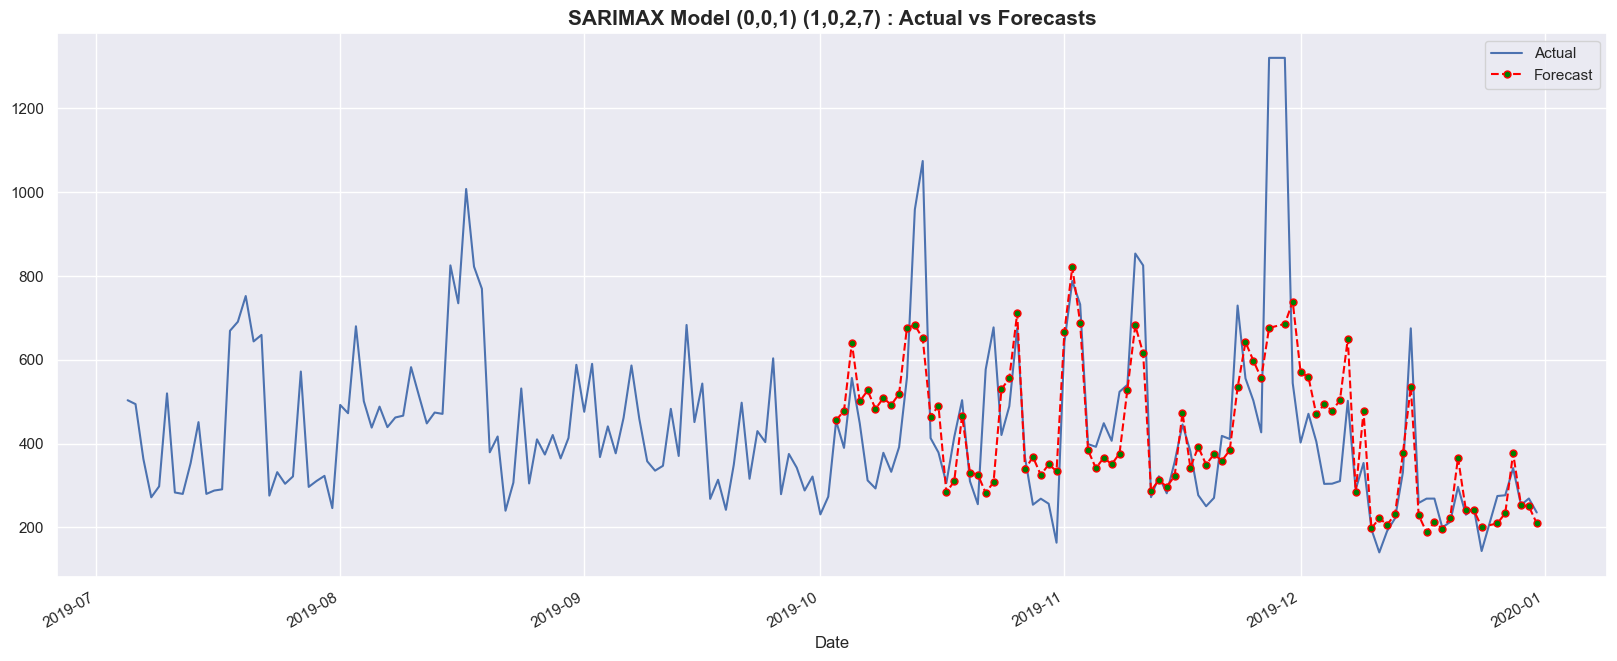

--------------------------------------------------------------------------------
MAPE of Model : 0.23389
--------------------------------------------------------------------------------
RMSE of Model : 167.024
--------------------------------------------------------------------------------


In [196]:
#Plotting the SARIMAX model corresponding to best parameters

time_series = df_Product156.Quantity
exog = exog_156.to_numpy()
n = 90

p,d,q, P,D,Q,s = 0,0,1, 1,0,2,7

sarimax_model(time_series, n, p=p, d=d, q=q, P=P, D=D, Q=Q, s=s, exog = exog)

## Function to make predictions for top 5 products

In [258]:
top10products

['Product 156',
 'Product 147',
 'Product 154',
 'Product 22',
 'Product 155',
 'Product 2',
 'Product 1',
 'Product 19',
 'Product 12',
 'Product 3']

In [255]:
def SARIMAX_all_products(top10products, df_sales):
    for product in top10products:
        
        print(f'--------------------------------------------------------------')
        print(f'  {product} calculation started ')
        print(f'--------------------------------------------------------------')
    
        df_Product = outlier_missing(product, df_sales)
        exog = exogenous_variable(df_Product)
        
        time_series = df_Product.Quantity
        n = 90 
        param = [0,1,2]
        d_param = [0,1]
        #param = [0,1]
        #d_param = [0]
        s_param = [7]
        exog = exog.to_numpy()
        
        params_Product  = sarimax_grid_search(time_series, n, param, d_param,s_param, exog)
        params_Product = params_Product.sort_values(['mape', 'rmse'])
        
        best_p = params_Product.iloc[0].pdq[0]
        best_d = params_Product.iloc[0].pdq[1]
        best_q = params_Product.iloc[0].pdq[2]
        best_P = params_Product.iloc[0].PDQs[0]
        best_D = params_Product.iloc[0].PDQs[1]
        best_Q = params_Product.iloc[0].PDQs[2]
        best_s = params_Product.iloc[0].PDQs[3]
        best_mape = params_Product.iloc[0].mape
        best_rmse = params_Product.iloc[0].rmse

        best_mape = np.round(best_mape, 5)      
        
        print(f'--------------------------------------------------------------')
        print(f'Minimum MAPE for {product} = {best_mape}')
        print(f'Corresponding Best Parameters are {best_p , best_d, best_q, best_P, best_D, best_Q, best_s}')
        print(f'--------------------------------------------------------------')
        
        #Plotting the SARIMAX model corresponding to best parameters

        time_series = df_Product.Quantity
        n = 90
        p,d,q, P,D,Q,s = best_p , best_d, best_q, best_P, best_D, best_Q, best_s

        sarimax_model(time_series, n, p=p, d=d, q=q, P=P, D=D, Q=Q, s=s, exog = exog)
        

--------------------------------------------------------------
  Product 147 calculation started 
--------------------------------------------------------------
Possible Combination: 18 out of 324 calculated
Possible Combination: 36 out of 324 calculated
Possible Combination: 54 out of 324 calculated
Possible Combination: 72 out of 324 calculated
Possible Combination: 90 out of 324 calculated
Possible Combination: 108 out of 324 calculated
Possible Combination: 126 out of 324 calculated
Possible Combination: 144 out of 324 calculated
Possible Combination: 162 out of 324 calculated
Possible Combination: 180 out of 324 calculated
Possible Combination: 198 out of 324 calculated
Possible Combination: 216 out of 324 calculated
Possible Combination: 234 out of 324 calculated
Possible Combination: 252 out of 324 calculated
Possible Combination: 270 out of 324 calculated
Possible Combination: 288 out of 324 calculated
Possible Combination: 306 out of 324 calculated
Possible Combination: 324 ou

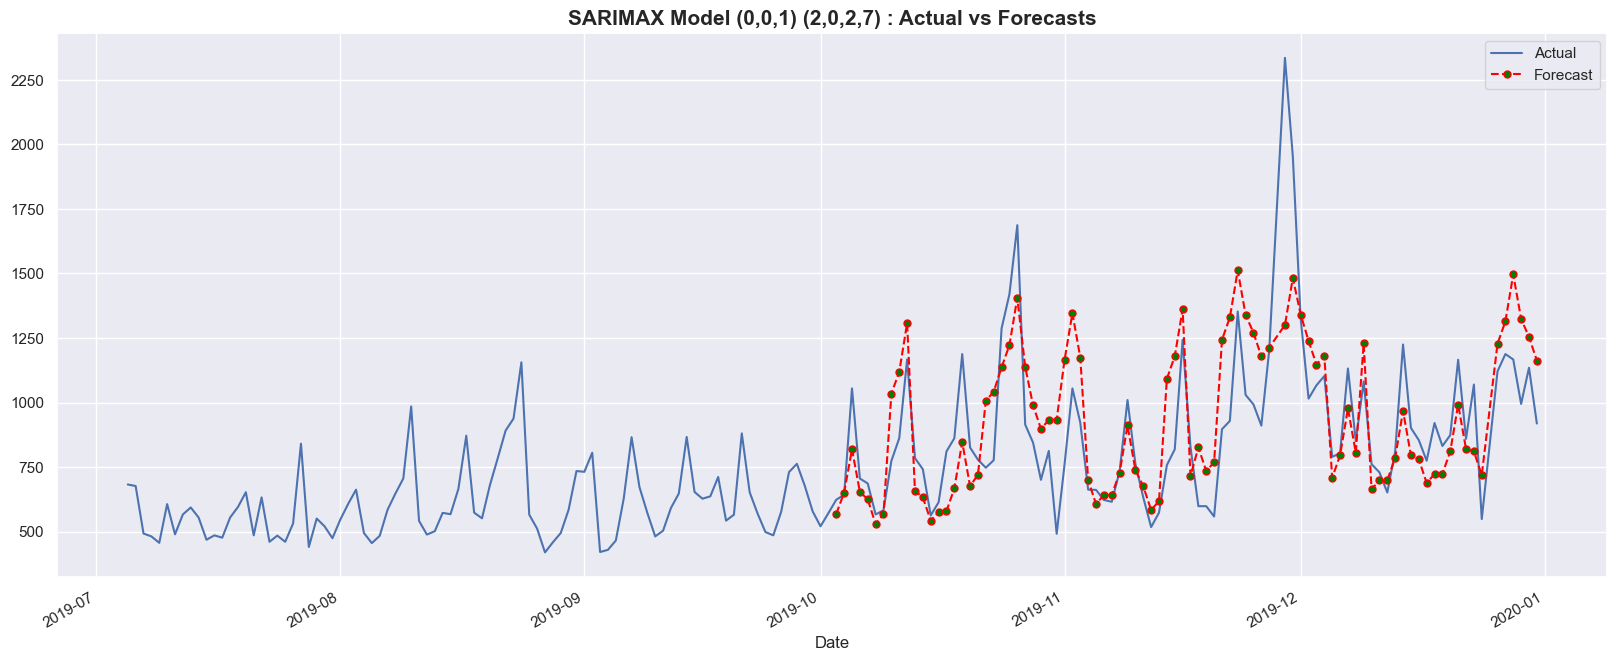

--------------------------------------------------------------------------------
MAPE of Model : 0.18133
--------------------------------------------------------------------------------
RMSE of Model : 227.96
--------------------------------------------------------------------------------
--------------------------------------------------------------
  Product 154 calculation started 
--------------------------------------------------------------
Possible Combination: 18 out of 324 calculated
Possible Combination: 36 out of 324 calculated
Possible Combination: 54 out of 324 calculated
Possible Combination: 72 out of 324 calculated
Possible Combination: 90 out of 324 calculated
Possible Combination: 108 out of 324 calculated
Possible Combination: 126 out of 324 calculated
Possible Combination: 144 out of 324 calculated
Possible Combination: 162 out of 324 calculated
Possible Combination: 180 out of 324 calculated
Possible Combination: 198 out of 324 calculated
Possible Combination: 216 

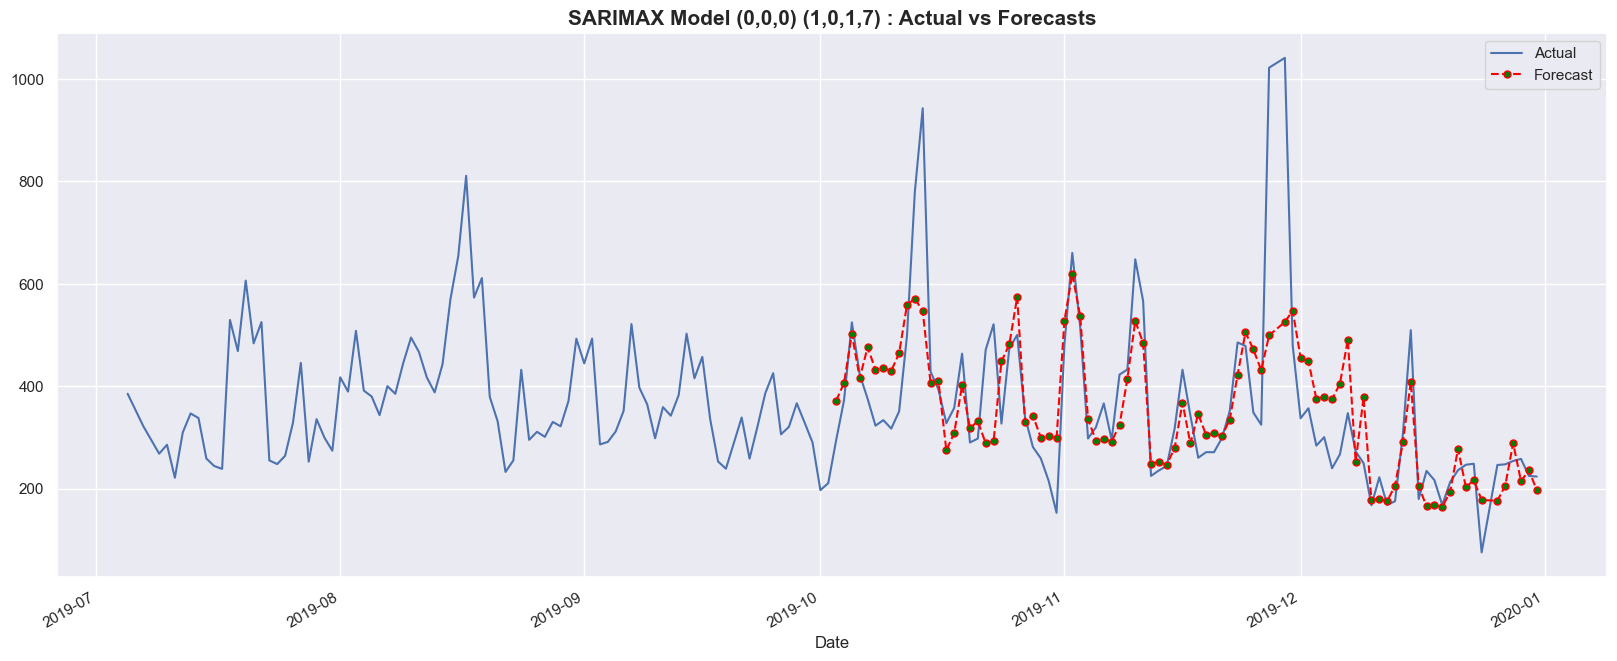

--------------------------------------------------------------------------------
MAPE of Model : 0.21475
--------------------------------------------------------------------------------
RMSE of Model : 129.393
--------------------------------------------------------------------------------
--------------------------------------------------------------
  Product 22 calculation started 
--------------------------------------------------------------
Possible Combination: 18 out of 324 calculated
Possible Combination: 36 out of 324 calculated
Possible Combination: 54 out of 324 calculated
Possible Combination: 72 out of 324 calculated
Possible Combination: 90 out of 324 calculated
Possible Combination: 108 out of 324 calculated
Possible Combination: 126 out of 324 calculated
Possible Combination: 144 out of 324 calculated
Possible Combination: 162 out of 324 calculated
Possible Combination: 180 out of 324 calculated
Possible Combination: 198 out of 324 calculated
Possible Combination: 216 

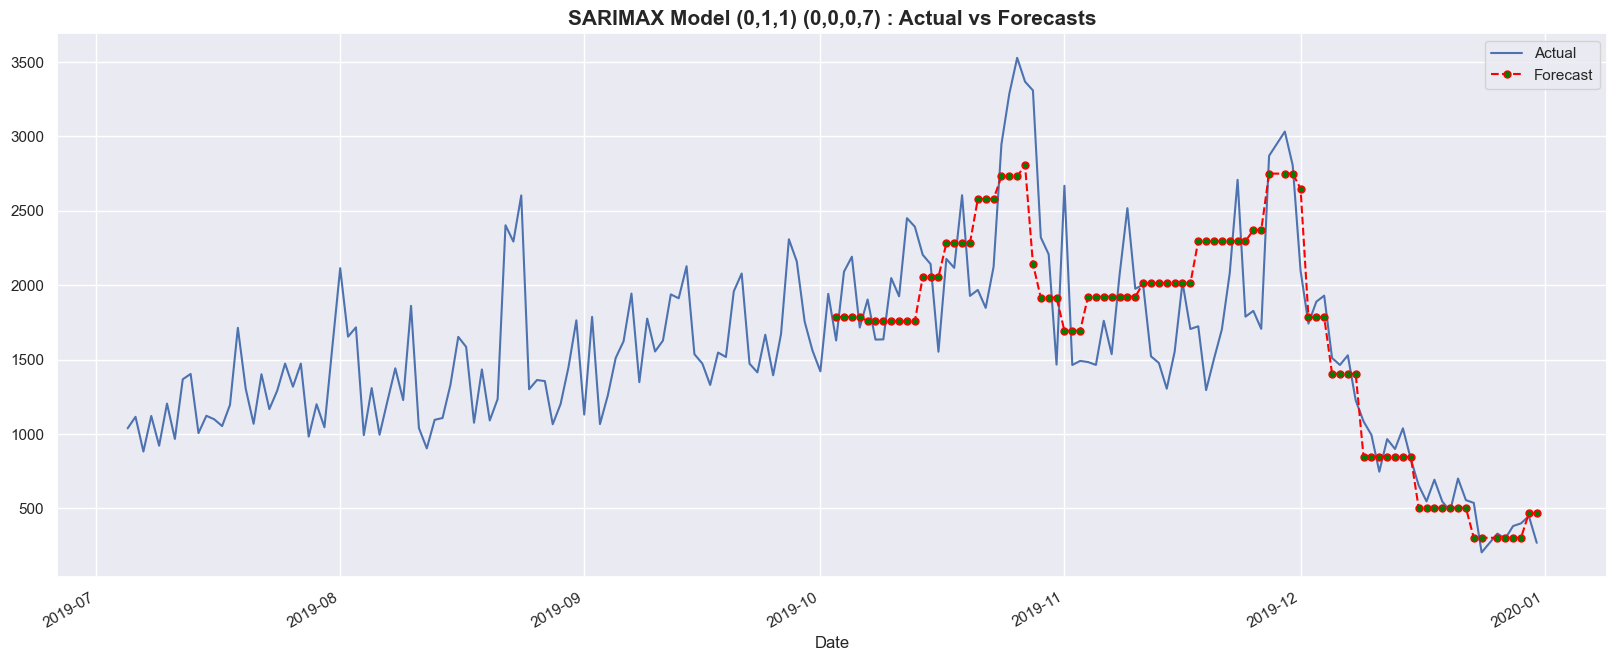

--------------------------------------------------------------------------------
MAPE of Model : 0.18925
--------------------------------------------------------------------------------
RMSE of Model : 392.464
--------------------------------------------------------------------------------
--------------------------------------------------------------
  Product 155 calculation started 
--------------------------------------------------------------
Possible Combination: 18 out of 324 calculated
Possible Combination: 36 out of 324 calculated
Possible Combination: 54 out of 324 calculated
Possible Combination: 72 out of 324 calculated
Possible Combination: 90 out of 324 calculated
Possible Combination: 108 out of 324 calculated
Possible Combination: 126 out of 324 calculated
Possible Combination: 144 out of 324 calculated
Possible Combination: 162 out of 324 calculated
Possible Combination: 180 out of 324 calculated
Possible Combination: 198 out of 324 calculated
Possible Combination: 216

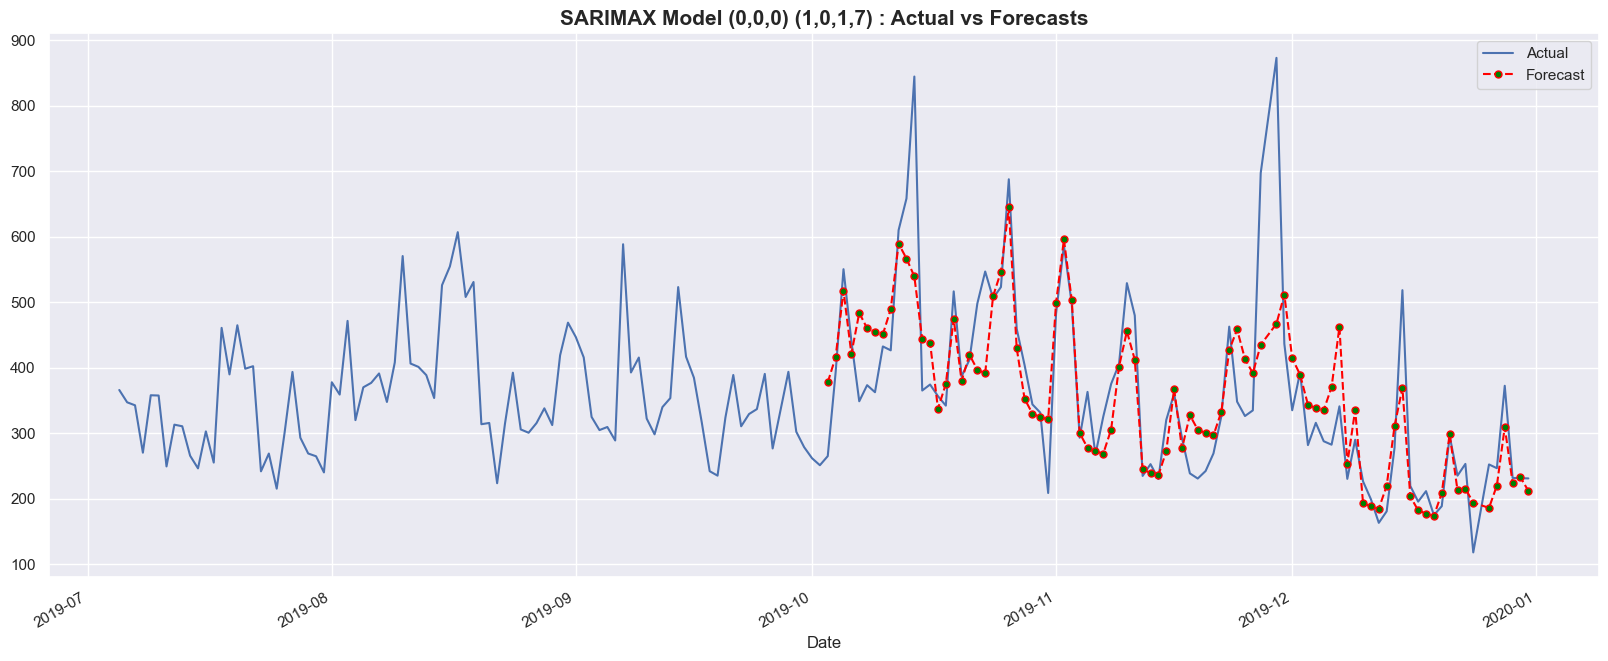

--------------------------------------------------------------------------------
MAPE of Model : 0.15001
--------------------------------------------------------------------------------
RMSE of Model : 90.686
--------------------------------------------------------------------------------
--------------------------------------------------------------
  Product 2 calculation started 
--------------------------------------------------------------
Possible Combination: 18 out of 324 calculated
Possible Combination: 36 out of 324 calculated
Possible Combination: 54 out of 324 calculated
Possible Combination: 72 out of 324 calculated
Possible Combination: 90 out of 324 calculated
Possible Combination: 108 out of 324 calculated
Possible Combination: 126 out of 324 calculated
Possible Combination: 144 out of 324 calculated
Possible Combination: 162 out of 324 calculated
Possible Combination: 180 out of 324 calculated
Possible Combination: 198 out of 324 calculated
Possible Combination: 216 ou

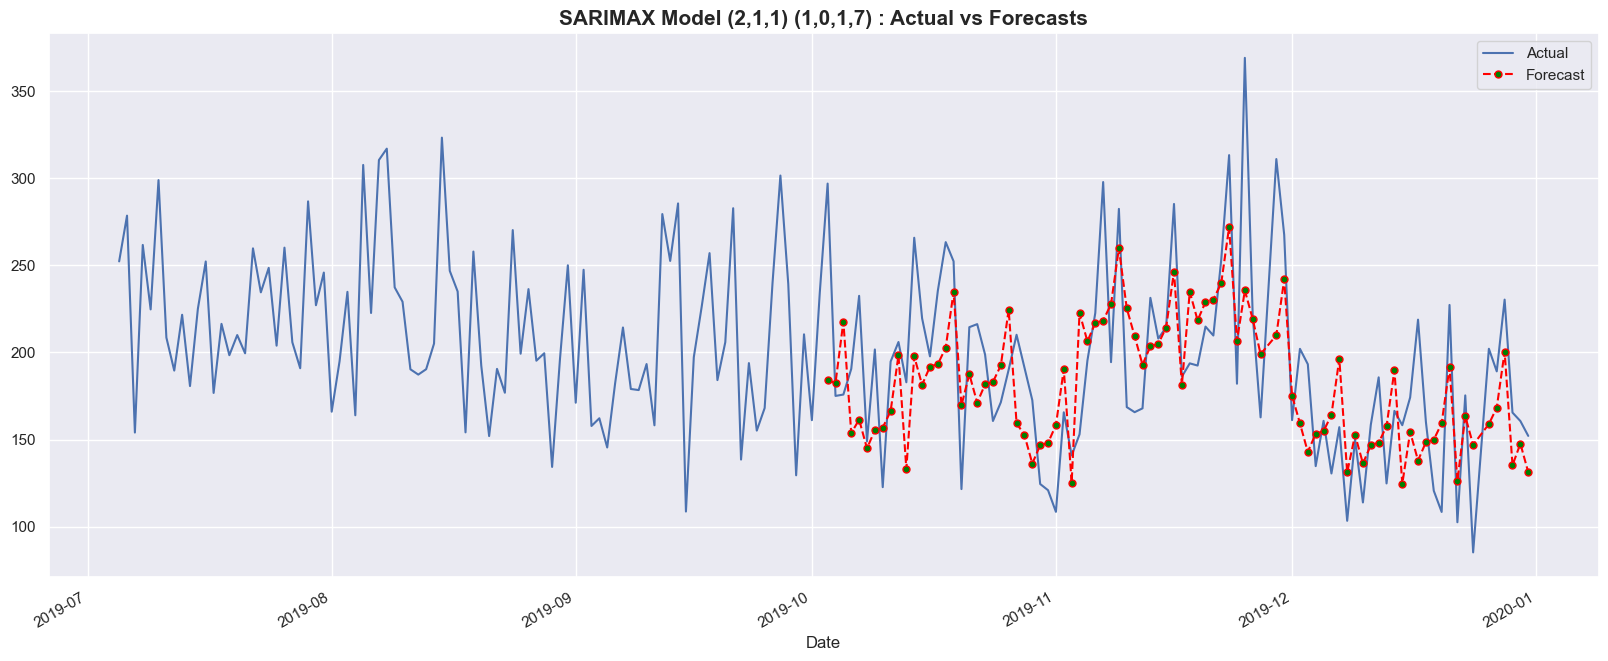

--------------------------------------------------------------------------------
MAPE of Model : 0.18039
--------------------------------------------------------------------------------
RMSE of Model : 40.693
--------------------------------------------------------------------------------


In [257]:
SARIMAX_all_products(top10products[1:6], df_sales)

## Summary of MAPE for Top 5 Products


- Product   vs MAPE
- Product 56 :   23%
- Product 147:   18%
- Product 154:   21%
- Product 22 :   19%
- Product 155:   15%  
- Product 2  :   18%


> MAPE for Top 5 products range between 15% to 23%

## Future scope of improvements

 - These models were hyperparameter tunned based on MAPE. Based on business expectations models can be tunned to optimise
     - AIC / BIC score
     - RMSE
     - Greater Hyperparameter tunning (taking wider range of parameters (p,d,q,P,D,Q,s)
     
 - Other Machine Learning models can also be tried to check performance like
     - Prophet by Facebook
     - AutoArima model (automatic ARIMA hyperparameter tunning)
     - Triple exponential smoothing model
     - Deep Learning / Neural Networks e.g. LSTM based models
     - Decision Tree based models like GBDT (xgBoost, LightBoost etc.), RandomForest by creating features based on past values
     - Also an ENSEMBLE model to combine output from all above models and optimized output from all models

  - If possible try to capture more external factors which can impact sales (depending upon type of product)
      - Environment based factors (Temperature, Season, Raining, etc.)
      - Geographical based factors 
      - Political factors (change in policies by governments)
      - Capturing non-tabular data inputs (images)
      - Inputs from Social media

## ------------------------------------------------- END ---------------------------------------------------------